In [ ]:
import pandas as pd
df = pd.read_csv('us-states.csv',error_bad_lines=False)

In [ ]:
NY = df[df.state == 'New York'].reset_index()

In [ ]:
NY

,index,date,state,fips,cases,deaths
0,246,2020-03-01,New York,36,1,0
1,261,2020-03-02,New York,36,1,0
2,276,2020-03-03,New York,36,2,0
3,293,2020-03-04,New York,36,11,0
4,313,2020-03-05,New York,36,22,0
...,...,...,...,...,...,...
413,22652,2021-04-18,New York,36,1996876,51077
414,22707,2021-04-19,New York,36,2002053,51122
415,22762,2021-04-20,New York,36,2006712,51183
416,22817,2021-04-21,New York,36,2010967,51228


In [ ]:
NY = NY[['date','cases','deaths']]

In [ ]:
NY['cases']

0            1
1            1
2            2
3           11
4           22
        ...   
413    1996876
414    2002053
415    2006712
416    2010967
417    2016244
Name: cases, Length: 418, dtype: int64

### Stationarity test of cumulative

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(NY['deaths'])

In [ ]:
pvalue

0.040153474298710176

In [ ]:
Daily_Deaths = []
Daily_cases = []
for index, row in NY.iterrows():
  if index == 0:
    prevRow = row
    Daily_cases.append(row['cases'])
    Daily_Deaths.append(row['deaths'])
    continue
  else:
    if row['deaths'] < prevRow['deaths']:
      Daily_Deaths.append(Daily_Deaths[-1])
    else:
      Daily_Deaths.append(row['deaths'] - prevRow['deaths'])
    if row['cases'] < prevRow['cases']:
      Daily_cases.append(Daily_cases[-1])
    else:
      Daily_cases.append(row['cases'] - prevRow['cases'])
    prevRow = row

### Stationarity test of Daily

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(Daily_Deaths)
pvalue

0.024167465823232058

In [ ]:
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm

#set parameter range
p = range(0,3)
q = range(1,3)
d = range(1,2)
s = [7,30,60,180,365]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(Daily_cases,order=param,seasonal_order=param_seasonal)
      results = mod.fit(max_iter = 50, method = 'powell')
      print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
      continue

Optimization terminated successfully.
         Current function value: 7.538975
         Iterations: 3
         Function evaluations: 119
SARIMA(0, 1, 1),(0, 1, 1, 7) - AIC:6218.115098328679


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Optimization terminated successfully.
         Current function value: 7.192158
         Iterations: 3
         Function evaluations: 120
SARIMA(0, 1, 1),(0, 1, 1, 30) - AIC:5932.338543863345
Optimization terminated successfully.
         Current function value: 6.662808
         Iterations: 3
         Function evaluations: 114
SARIMA(0, 1, 1),(0, 1, 1, 60) - AIC:5496.153738335497
Optimization terminated successfully.
         Current function value: 7.528373
         Iterations: 3
         Function evaluations: 153
SARIMA(0, 1, 1),(0, 1, 2, 7) - AIC:6211.379311574439
Optimization terminated successfully.
         Current function value: 7.181206
         Iterations: 3
         Function evaluations: 152
SARIMA(0, 1, 1),(0, 1, 2, 30) - AIC:5925.3139552342955
Optimization terminated successfully.
         Current function value: 7.528946
         Iterations: 4
         Function evaluations: 201
SARIMA(0, 1, 1),(1, 1, 1, 7) - AIC:6211.851355268864
Optimization terminated successfully.
   

In [ ]:
#NY Daily Cases: SARIMA(2, 1, 2),(1, 1, 1, 7) - AIC:7020.763322288931
#NY Deaths (2, 1, 1),(1, 1, 1, 7) 
#VA Deaths SARIMA(1, 1, 1),(0, 1, 1, 7)

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm

def walk_forward_validation(data, n_test):
    predictions = np.array([])
    mape_list = []
    train, test = data[:n_test], data[n_test:]
    day_list = [7,14,21,28] # weeks 1,2,3,4
    model = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order = (1,1,1,21))
    model = model.fit(max_iter = 50,method = 'powell')
    forecast = model.forecast(steps = len(test))
    #predictions = np.concatenate((predictions, forecast),axis=None)
    mape_score = (abs(test-forecast)/test)
    mape_mean = mape_score.mean()
    return forecast, mape_mean

In [ ]:
data = Daily_cases
n_test = int(0.80*len(data))
train, test = data[:n_test], data[n_test:]
predictions, mape_mean = walk_forward_validation(data,n_test)
print(mape_mean)

Optimization terminated successfully.
         Current function value: 7.767365
         Iterations: 5
         Function evaluations: 316
0.9327929975731715


In [ ]:
from sklearn.metrics import r2_score
r2_score(test, predictions)

-7.840276918641205

In [ ]:
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(test, predictions))

6528.496573717661

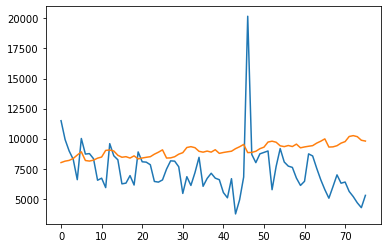

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test)
plt.plot(predictions)